In [79]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td
import pyhrv

In [ ]:
# set up an empty features file
df_features = pd.DataFrame(None, columns= ['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 
                                     'feat_sdsd', 'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf','peak hf', 'norm power lf', 
                                     'norm power hf', 'power ratio', 'total power'])
#print(df_features)
write_to_csv(df_features, "out_features.csv")


In [ ]:
# get features from all signals and write to a csv file

fs = 700
y = []
for label in range(1,5):
    file = "out_" + str(label) + ".csv"

    df = read_from_csv(file)

    for subject in df:
        if subject != 'Unnamed: 0':
            if label == 3 or label == 4:
                y.append(1)
            else:
                y.append(label)
            ecg = df[subject]
            ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
            rpeaks = ecg_td['rpeaks']
            filtered_ecg = ecg_td['filtered']
            df_features = get_features(rpeaks, fs, df_features, subject+str(label))

write_to_csv(df_features, "out_features.csv")

In [ ]:
# Function that reads a csv file and outputs a data frame
def read_from_csv(file):
    data_frame = pd.read_csv(file, sep=",")
    return data_frame

In [ ]:
# Function that writes a data frame to a csv file
def write_to_csv(df, file):
    df.to_csv(index=False)
    location = "C:/Users/riche/OneDrive/Documenten/Github/EPO4-C2/"
    path = location + file
    os.makedirs(location, exist_ok=True)  
    df.to_csv(path)

In [ ]:
# filtering
def filter_signal(ecg, fs):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
    filtered_ecg = ecg_td['filtered']
    # nyq = 0.5*fs
    # order=5

    # # highpass filter
    # high=0.5
    # high= high/nyq
    # b, a = butter(order, high, 'highpass')
    # ecg_h = lfilter(b,a,ecg)

    # # lowpass filter
    # low = 70
    # low= low/nyq
    # b, a = butter(order, low, 'lowpass')
    # ecg_hl = lfilter(b,a,ecg_h)

    # # notch filter
    # notch=50
    # notch = notch/nyq
    # b, a = iirnotch(notch, 30, fs)
    # ecg_hln = lfilter(b,a,ecg_hl)

    # t=np.arange(0,ecg.size*(1/fs),(1/fs))
    # t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,ecg_hln, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend()
    return filtered_ecg

In [ ]:
# detect R-peaks
def detect_rpeaks(fs, ecg_hln):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
    rpeaks = ecg_td['rpeaks']
    # detectors = Detectors(fs)

    # r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
    # r_peaks_pan = np.asarray(r_peaks_pan)

    # plt.figure(figsize=(12,4))
    # plt.plot(ecg_hln)
    # plt.plot(r_peaks_pan,ecg_hln[r_peaks_pan], 'ro')
    return rpeaks

# **Feature extraction**

In [ ]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(r_peaks_pan, fs, df, index):
    features = []
    ecg_fft = fd.frequency_domain(rpeaks = r_peaks_pan, show = False)
    plt.close(ecg_fft["ar_plot"])
    plt.close(ecg_fft["lomb_plot"])
    plt.close(ecg_fft["fft_plot"])
    hrv_class = HRV(fs)
    # print(r_peaks_pan)
    #Number of pairs of succesive NNs that differ by more than 20ms(NN20)
    features.append(hrv_class.NN20(r_peaks_pan))
    # print(f"nn20:{feat_nn20}")
    #Number of pairs of succesive NNs that differ by more than 50ms(NN50)
    features.append(hrv_class.NN50(r_peaks_pan))
    # print(f"nn50:{feat_nn50}")
    #Root mean square of succesive differences(RMSSD)
    features.append(hrv_class.RMSSD(r_peaks_pan, normalise= True))
    # print(f"rmssd:{feat_rmssd}")
    #Heart-rate feature extraction in BPM(HR)
    features.append(np.mean(hrv_class.HR(r_peaks_pan)))
    # print(f"HR:{feat_hr}")
    #Standard deviation of succesive differences(SDSD)
    features.append(hrv_class.SDSD(r_peaks_pan))
    # print(f"SDSD:{feat_sdsd}")
    #The proportion of NN50 divided by total number of NNs(pNN50)
    features.append(hrv_class.pNN50(r_peaks_pan))
    # print(f"pNN50:{feat_pnn50}")
    #The proportion of NN20 divided by total number of NNs(pNN20)
    features.append(hrv_class.pNN20(r_peaks_pan))
    # print(f"pNN20:{feat_pnn20}")
    features.extend([ecg_fft['fft_peak'][0], ecg_fft['fft_peak'][1], ecg_fft['fft_peak'][2], ecg_fft['fft_norm'][0],
                     ecg_fft['fft_norm'][1], ecg_fft['fft_ratio'], ecg_fft['fft_total']])
    #The
    
    df.loc[index] = features
    return df

In [ ]:
df_features.head()
print(y)

# **Respiration**

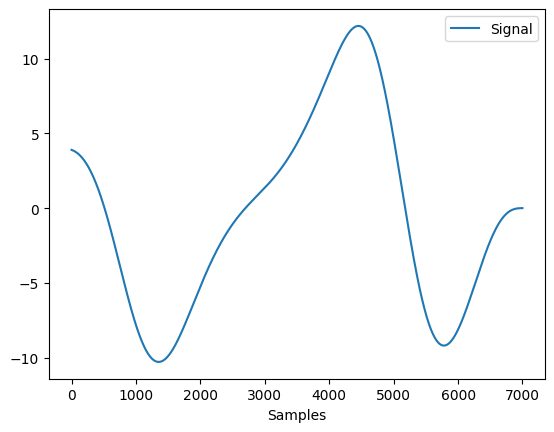

In [282]:
fs =700
subject ='S20'
df_ecg = read_from_csv('ecg_1.csv')
ecg =df_ecg[subject]

filtered_ecg = filter_signal(ecg, fs)
rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=fs)
ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg))
edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs)
resp_peaks1, _ = signal.find_peaks(edr, height=0, distance=4)
nk.signal_plot(edr)


In [ ]:
from scipy.interpolate import splrep, splev

fs =700
subject ='S20'
df_ecg = read_from_csv('ecg_1.csv')
ecg =df_ecg[subject]
ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
rr = ecg_td['rpeaks']
filtered_ecg = ecg_td['filtered']

fs = 700
# rr = rpeaks
rr = (rr / fs) * 1000
rri = np.diff(rr)
print(rri)

def interp_cubic_spline(rri, sf_up=4):
    rri_time = np.cumsum(rri) / 1000.0
    time_rri = rri_time - rri_time[0]
    time_rri_interp = np.arange(0, time_rri[-1], 1 / float(sf_up))
    tck = splrep(time_rri, rri, s=0)
    rri_interp = splev(time_rri_interp, tck, der=0)
    return rri_interp

sf_up = 4
rri_interp = interp_cubic_spline(rri, sf_up) 
hr = 1000 * (60 / rri_interp)
print('Mean HR: %.2f bpm' % np.mean(hr))

# Detrend and normalize
edr = signal.detrend(hr)
edr = (edr - edr.mean()) / edr.std()

# Find respiratory peaks
resp_peaks, _ = signal.find_peaks(edr, height=0, distance=sf_up)

# Convert to seconds
resp_peaks = resp_peaks
resp_peaks_diff = np.diff(resp_peaks) / sf_up

# Plot the EDR waveform
plt.plot(edr)
plt.plot(resp_peaks, edr[resp_peaks], 'o')
_ = plt.title('ECG derived respiration')

[463, 2104, 2230, 4669, 4731, 6736]


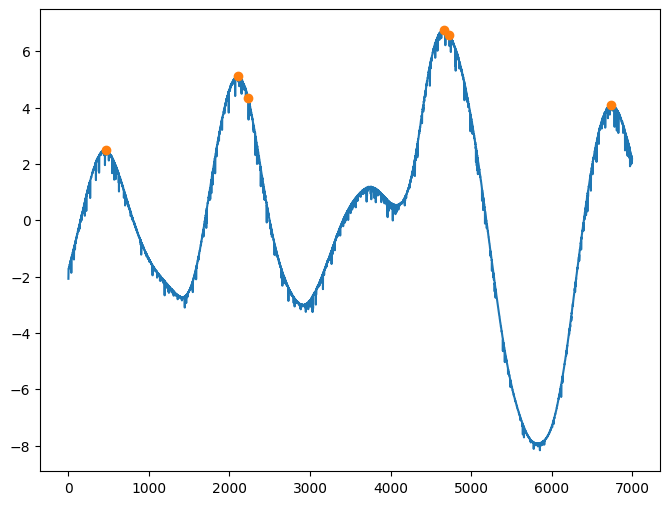

In [284]:
# Visual comparison
df_resp = read_from_csv('resp_1.csv')
resp=df_resp[subject]

# rpeaks, info = nk.ecg_peaks(resp, sampling_rate=fs)
resp_peaks2, _ = signal.find_peaks(resp, height=2, distance=30)
maxi = 0
begini = 0
peaks = []

for i in range(len(resp_peaks2)):
    if resp_peaks2[i] >= resp_peaks2[begini] + 400:
        begini = i
        peaks.append(resp_peaks2[maxi])
        maxi = i

    if resp[resp_peaks2[i]]> resp[resp_peaks2[maxi]]:
        maxi = i

print(peaks)
plt.figure(figsize=(8,6))
plt.plot(resp)
plt.plot(peaks, resp[peaks], 'o')

In [285]:
print(len(resp_peaks1),len(resp_peaks2))

print(peaks)
print(resp_peaks1, resp_peaks)

1 67
[463, 2104, 2230, 4669, 4731, 6736]
[4453] [13 22]


# **PCA**

In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [152]:
df_features.keys()

Index(['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 'feat_sdsd',
       'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf', 'peak hf',
       'norm power lf', 'norm power hf', 'power ratio', 'total power'],
      dtype='object')

In [153]:
print(len(y), df_features.shape)

180 (180, 14)


In [154]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=4)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [254]:
score=[]
print(df_features.shape)
for i in range (1,50):
    X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=i)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    pca = PCA(n_components=7)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    score.append(model.score(X_test, y_test))
print(score)
print(np.mean(score))
#7 components gives an accuracy of 83.5%#nt(np.skew)wirite a code that can detect stress from ecg

(180, 14)
[0.8148148148148148, 0.8703703703703703, 0.7962962962962963, 0.9074074074074074, 0.7407407407407407, 0.8148148148148148, 0.8703703703703703, 0.8888888888888888, 0.8333333333333334, 0.7222222222222222, 0.7962962962962963, 0.8518518518518519, 0.8703703703703703, 0.8703703703703703, 0.7962962962962963, 0.7962962962962963, 0.8703703703703703, 0.8148148148148148, 0.8888888888888888, 0.7962962962962963, 0.8888888888888888, 0.8148148148148148, 0.7592592592592593, 0.7962962962962963, 0.8888888888888888, 0.8518518518518519, 0.8888888888888888, 0.7777777777777778, 0.7962962962962963, 0.8333333333333334, 0.8333333333333334, 0.8518518518518519, 0.8333333333333334, 0.7592592592592593, 0.8518518518518519, 0.8333333333333334, 0.9074074074074074, 0.8148148148148148, 0.9074074074074074, 0.8148148148148148, 0.7962962962962963, 0.8703703703703703, 0.8333333333333334, 0.7962962962962963, 0.8518518518518519, 0.9074074074074074, 0.8148148148148148, 0.8888888888888888, 0.8518518518518519]
0.8352229

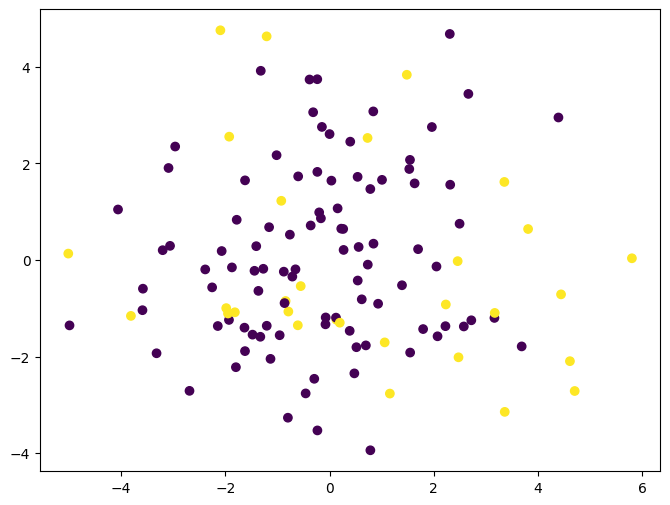

In [156]:
pca = PCA(n_components=4) 
pca = pca.fit(X_train)

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)

In [157]:
model = LogisticRegression()
model.fit(X_train_pca, y_train)
print(model.score(X_test_pca, y_test))

0.8148148148148148


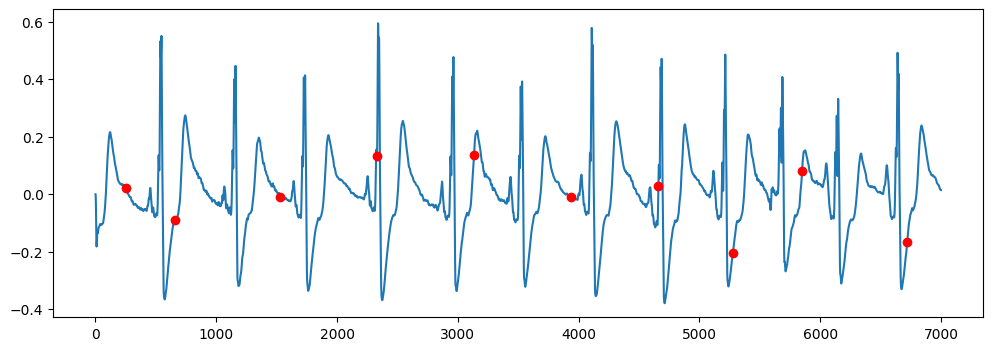

In [158]:
plt.figure(figsize=(12,4))
plt.plot(filtered_ecg)
plt.plot(r_peaks_pan,filtered_ecg[r_peaks_pan], 'ro')


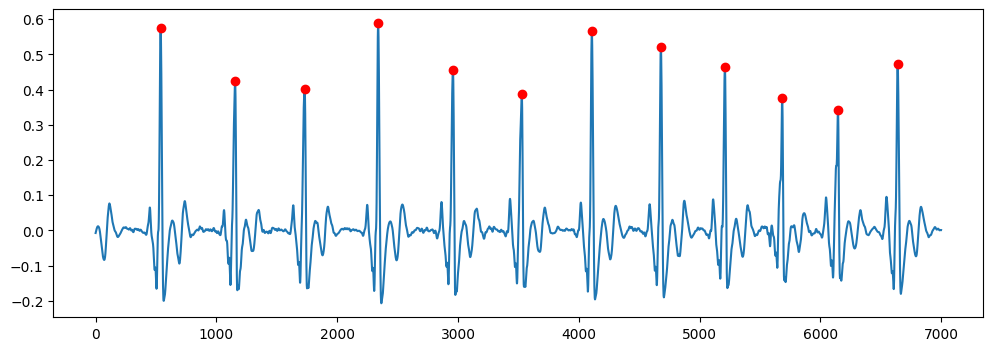

In [159]:
ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)
t = ecg_td['ts']

plt.figure(figsize=(12,4))
rpeaks = ecg_td['rpeaks']
filtered_signal = ecg_td['filtered']
plt.plot(filtered_signal)
plt.plot(rpeaks,filtered_signal[rpeaks], 'ro')


In [160]:
hrv_class = HRV(fs)
print(td.hr_parameters(rpeaks = t[rpeaks]))
print(hrv_class.HR(rpeaks))
print(np.mean(hrv_class.HR(rpeaks)))

print(td.hr_parameters(rpeaks = t[rpeaks]))
print(hrv_class.HR(r_peaks_pan))

print(td.nn20(rpeaks = t[rpeaks]))
print(hrv_class.NN20(rpeaks))
print(hrv_class.pNN20(rpeaks))
print(td.nn50(rpeaks = t[rpeaks]))
print(hrv_class.NN50(rpeaks))
print(hrv_class.pNN50(rpeaks))

print(td.rmssd(rpeaks=t[rpeaks]))
print(hrv_class.RMSSD(rpeaks))

print(td.sdnn(rpeaks=t[rpeaks]))
print(hrv_class.SDNN(rpeaks))



ReturnTuple(hr_mean=76.53326682134467, hr_min=67.87330316742081, hr_max=91.1854103343465, hr_std=8.288319667326382)
[68.0713128  73.04347826 68.96551724 67.85137318 73.68421053 72.4137931
 73.55516637 79.24528302 88.42105263 91.10629067 85.02024291]
76.48888370282856
ReturnTuple(hr_mean=76.53326682134467, hr_min=67.87330316742081, hr_max=91.1854103343465, hr_std=8.288319667326382)
[101.69491525  48.44290657  52.36907731  52.36907731  52.17391304
  58.17174515  68.0713128   73.42657343  48.27586207]
ReturnTuple(nn20=6, pnn20=60.0)
6
0.5454545454545454
ReturnTuple(nn50=4, pnn50=40.0)
4
0.36363636363636365
ReturnTuple(rmssd=48.65799009412534)
48.64070689604484
ReturnTuple(sdnn=80.84856776153124)
76.98221062190115
